In [2]:
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
rf.stylely()
%matplotlib notebook

/Users/rik/anaconda/envs/spy/lib/python3.7/site-packages/skrf/plotting.py:1411: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  mpl.style.use(os.path.join(pwd, style_file))


For simplicity we look to a single frequency

In [3]:
frq = rf.Frequency(55,55,1,'mhz')

We now crate a network object for each components

In [5]:
hybA = rf.Network(name = 'hybrid_A')
hybB = rf.Network(name = 'hybrid_B')
phsC = rf.Network(name = 'phase_shift_coupl')

hybA.frequency = frq
hybB.frequency = frq
phsC.frequency = frq

We define the __S__ matrix of the hybrid coupler

In [6]:
_shyb = np.array([[[0, -1j/np.sqrt(2), -1/np.sqrt(2), 0],
                  [-1j/np.sqrt(2), 0, 0, -1/np.sqrt(2)],
                  [-1/np.sqrt(2), 0, 0, -1j/np.sqrt(2)],
                  [0, -1/np.sqrt(2), -1j/np.sqrt(2), 0]]])

We define a function that returns the __S__ matrix for thepahse shifter

In [7]:
def phase_shifter(phase):
    _sph = np.array([[0,np.exp(-1j*phase)],[np.exp(-1j*phase),0]])
    return _sph

In case we have more frequency points, we replicate the __S__ matrix of the hybrids for each frequency point. The result is a network with the same ideal response for each frequency.

In [8]:
hybA.s = np.repeat(_shyb, frq.npoints, axis=0)
hybB.s = np.repeat(_shyb, frq.npoints, axis=0)

We create the ports for the circuit network

In [10]:
port1 = rf.Circuit.Port(frq, 'port1', z0=50.)
port2 = rf.Circuit.Port(frq, 'port2', z0=50.)
port3 = rf.Circuit.Port(frq, 'port3', z0=50.)
port4 = rf.Circuit.Port(frq, 'port4', z0=50.)

We create replicate the __S__ matrix for the phase shifter for a given phase, e.g. 90 deg.

In [32]:
phsC.s = np.tile(phase_shifter(np.pi/2), frq.npoints)

We define the connections for the circuit

In [12]:
cnx = [
       [(port1, 0), (hybA, 0)],
       [(port2, 0), (hybB, 1)],
       [(port3, 0), (hybB, 2)],
       [(port4, 0), (hybA, 3)],
       [(hybA, 1), (hybB, 0)],
       [(hybA, 2), (phsC, 0)],
       [(phsC, 1), (hybB, 3)],        
       ]

We create the circuit and we check what is the amplitude at the two output for a given input on port 1

In [13]:
circuit = rf.Circuit(cnx)
out = circuit.network.s[0,:,:] @ np.array([1,0,0,0]).T
print(f'Output signal amplitude: {np.abs(out)}')

Output signal amplitude: [0.         0.70710678 0.70710678 0.        ]


We now define some auxiliary funcitons to make the plots

In [14]:
def sig(a,p):
    return a*np.exp(-1j*p)    

In [15]:
def prep_signal(s):
    r = np.abs(s)
    ph = np.angle(s)
    per = np.linspace(0,2*np.pi)
    return (per/np.pi,r*np.sin(per+ph))

In [16]:
 def cv(v):
    return np.array([v]).T

In [17]:
def calc(p1,p4,phase):
    _, pA2u, pA3u, _ = _shyb.squeeze() @ cv([p1,0,0,0])
    
    _, pS2u = phase_shifter(phase) @ cv([pA3u.tolist()[0],0])
    
    _, pB2u, pB3u, _ = _shyb.squeeze() @ cv([pA2u.tolist()[0],0,0,pS2u.tolist()[0]])
    
    _, pA2d, pA3d, _ = _shyb.squeeze() @ cv([0,0,0,p4])
    
    _, pS2d = phase_shifter(phase) @ cv([pA3d.tolist()[0],0])
    
    _, pB2d, pB3d, _ = _shyb.squeeze() @ cv([pA2d.tolist()[0],0,0,pS2d.tolist()[0]])
    
    _, pA2, pA3, _ = _shyb.squeeze() @ cv([p1,0,0,p4])
    
    _, pS2 = phase_shifter(phase) @ cv([pA3.tolist()[0],0])
    
    _, pB2, pB3, _ = _shyb.squeeze() @ cv([pA2.tolist()[0],0,0,pS2.tolist()[0]])
    
    return (pA2u,pA3u,pS2u,pB2u,pB3u,
            pA2d,pA3d,pS2d,pB2d,pB3d,
            pA2,pA3,pS2,pB2,pB3)

We create 2 signals for the two input ports (\#1, \#4)

In [18]:
p1 = sig(2,0)
p4 = sig(2,0)    
phase = -np.pi/2

pA2u,pA3u,pS2u,pB2u,pB3u,pA2d,pA3d,pS2d,pB2d,pB3d,pA2,pA3,pS2,pB2,pB3 = calc(p1,p4,phase)

We can plot the signals on each port of the hybrids to visualize the power flow of the variable coupler 

<IPython.core.display.Javascript object>


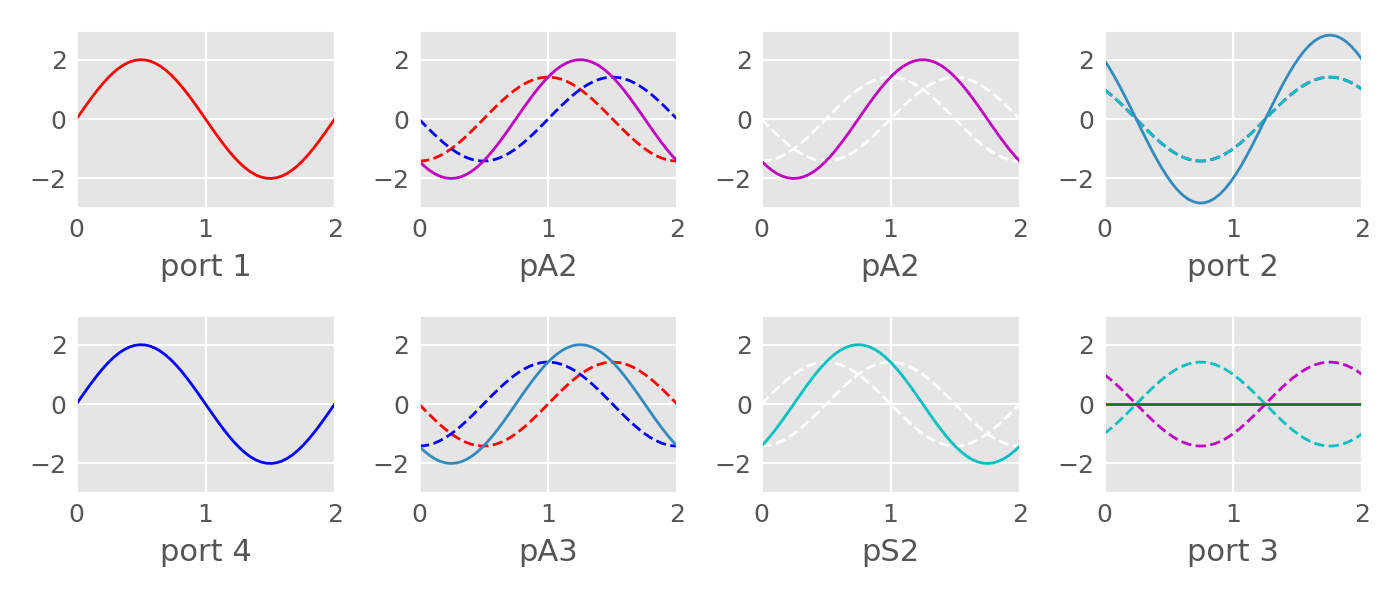

In [31]:
fig = plt.figure(figsize=(7,3))
lm = np.round(np.max(np.abs([pB2,pB3])))

ax1 = fig.add_subplot(2,4,1)
line11, = ax1.plot(*prep_signal(p1),'r')
plt.ylim(-lm,lm)
plt.xlabel('port 1')

ax2 = fig.add_subplot(2,4,2)
line21, = ax2.plot(*prep_signal(pA2u),'r--')
line22, = ax2.plot(*prep_signal(pA2d),'b--')
line23, = ax2.plot(*prep_signal(pA2),'m')
plt.ylim(-lm,lm)
plt.xlabel('pA2')

ax3 = fig.add_subplot(2,4,3)
line31, = ax3.plot(*prep_signal(pA2u),'w--')
line32, = ax3.plot(*prep_signal(pA2d),'w--')
line33, = ax3.plot(*prep_signal(pA2),'m')
plt.ylim(-lm,lm)
plt.xlabel('pA2')

ax4 = fig.add_subplot(2,4,4)
line41, = ax4.plot(*prep_signal(pB2u),'m--')
line42, = ax4.plot(*prep_signal(pB2d),'c--')
line43, = ax4.plot(*prep_signal(pB2))
plt.ylim(-lm,lm)
plt.xlabel('port 2')

ax5 = fig.add_subplot(2,4,5)
line51, = ax5.plot(*prep_signal(p4),'b')
plt.ylim(-lm,lm)
plt.xlabel('port 4')

ax6 = fig.add_subplot(2,4,6)
line61, = ax6.plot(*prep_signal(pA3u),'r--')
line62, = ax6.plot(*prep_signal(pA3d),'b--')
line63, = ax6.plot(*prep_signal(pA3))
plt.ylim(-lm,lm)
plt.xlabel('pA3')

ax7 = fig.add_subplot(2,4,7)
line71, = ax7.plot(*prep_signal(pS2u),'w--')
line72, = ax7.plot(*prep_signal(pS2d),'w--')
line73, = ax7.plot(*prep_signal(pS2),'c')
plt.ylim(-lm,lm)
plt.xlabel('pS2')

ax8 = fig.add_subplot(2,4,8)
line81, = ax8.plot(*prep_signal(pB3u),'m--')
line82, = ax8.plot(*prep_signal(pB3d),'c--')
line83, = ax8.plot(*prep_signal(pB3),'g')
plt.ylim(-lm,lm)
plt.xlabel('port 3')

plt.tight_layout()

<IPython.core.display.Javascript object>


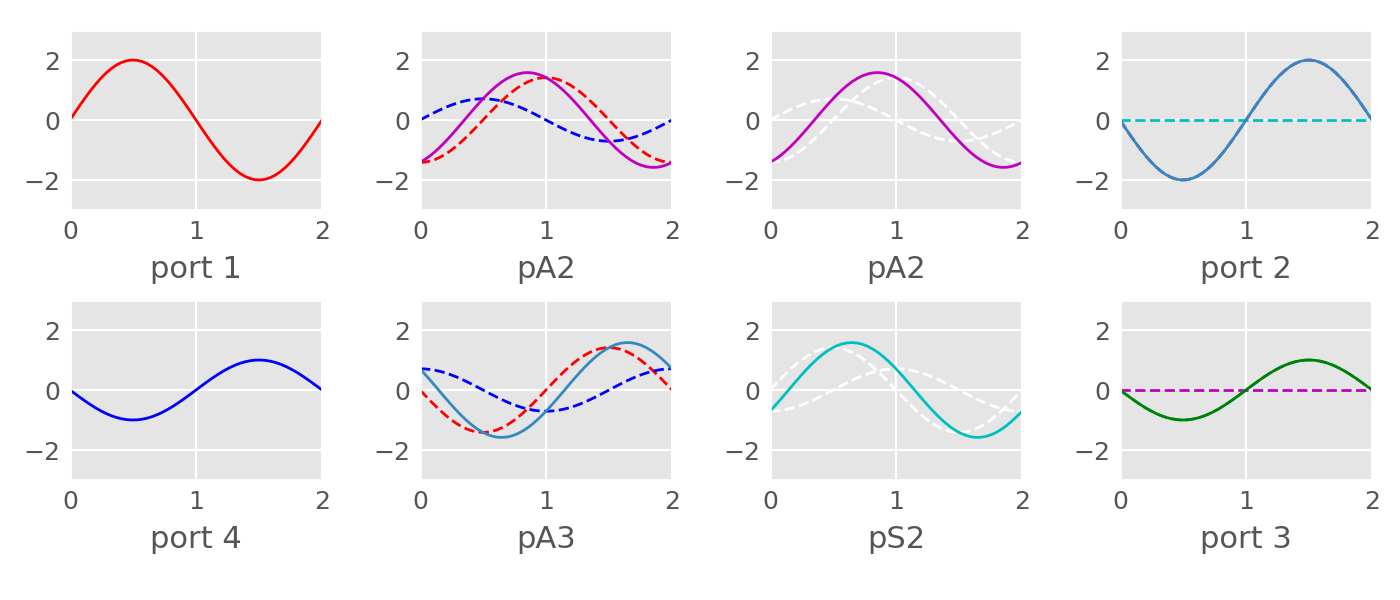

interactive(children=(FloatSlider(value=1.0, description='ph', max=2.0), FloatSlider(value=1.0, description='p…

In [33]:
fig = plt.figure('Response',figsize=(7,3))
#fig.clear()
lm = np.round(np.max(np.abs([pB2,pB3])))

#plot_ax = plt.axes([0.1, 0.1, 0.8, 0.65])
#phase_ax = plt.axes([0.06, 0.02, 0.35, 0.02])
#phase_ax2 = plt.axes([0.06, 0.05, 0.35, 0.02])
#ampli_ax = plt.axes([0.57, 0.05, 0.35, 0.02])

#plt.axes(plot_ax)
#ax1 = fig.add_subplot(2,4,1)
ax1 = fig.add_axes([0.05,0.65,0.18,0.30])
line11, = ax1.plot(*prep_signal(p1),'r')
plt.ylim(-lm,lm)
plt.xlabel('port 1')

#ax2 = fig.add_subplot(2,4,2)
ax2 = fig.add_axes([0.3,0.65,0.18,0.30])
line21, = ax2.plot(*prep_signal(pA2u),'r--')
line22, = ax2.plot(*prep_signal(pA2d),'b--')
line23, = ax2.plot(*prep_signal(pA2),'m')
plt.ylim(-lm,lm)
plt.xlabel('pA2')

#ax3 = fig.add_subplot(2,4,3)
ax3 = fig.add_axes([0.55,0.65,0.18,0.30])
line31, = ax3.plot(*prep_signal(pA2u),'w--')
line32, = ax3.plot(*prep_signal(pA2d),'w--')
line33, = ax3.plot(*prep_signal(pA2),'m')
plt.ylim(-lm,lm)
plt.xlabel('pA2')

#ax4 = fig.add_subplot(2,4,4)
ax4 = fig.add_axes([0.8,0.65,0.18,0.30])
line41, = ax4.plot(*prep_signal(pB2u),'m--')
line42, = ax4.plot(*prep_signal(pB2d),'c--')
line43, = ax4.plot(*prep_signal(pB2))
plt.ylim(-lm,lm)
plt.xlabel('port 2')

#ax5 = fig.add_subplot(2,4,5)
ax5 = fig.add_axes([0.05,0.2,0.18,0.30])
line51, = ax5.plot(*prep_signal(p4),'b')
plt.ylim(-lm,lm)
plt.xlabel('port 4')

#ax6 = fig.add_subplot(2,4,6)
ax6 = fig.add_axes([0.3,0.2,0.18,0.30])
line61, = ax6.plot(*prep_signal(pA3u),'r--')
line62, = ax6.plot(*prep_signal(pA3d),'b--')
line63, = ax6.plot(*prep_signal(pA3))
plt.ylim(-lm,lm)
plt.xlabel('pA3')

#ax7 = fig.add_subplot(2,4,7)
ax7 = fig.add_axes([0.55,0.2,0.18,0.30])
line71, = ax7.plot(*prep_signal(pS2u),'w--')
line72, = ax7.plot(*prep_signal(pS2d),'w--')
line73, = ax7.plot(*prep_signal(pS2),'c')
plt.ylim(-lm,lm)
plt.xlabel('pS2')

#ax8 = fig.add_subplot(2,4,8)
ax8 = fig.add_axes([0.8,0.2,0.18,0.30])
line81, = ax8.plot(*prep_signal(pB3u),'m--')
line82, = ax8.plot(*prep_signal(pB3d),'c--')
line83, = ax8.plot(*prep_signal(pB3),'g')
plt.ylim(-lm,lm)
plt.xlabel('port 3')

#fig.tight_layout()
#plt.title('Test')

@widgets.interact(a=(0,2.),ph=(0,2.),ph2=(0,2.))
def update(ph,ph2,a):
    #pA2u,pA3u,pS2u,pB2u,pB3u,pA2d,pA3d,pS2d,pB2d,pB3d,pA2,pA3,pS2,pB2,pB3 = calc(p1,p4,ph)
    #0    1    2    3    4    5    6    7    8    9    10  11  12  13  14
    p1 = sig(2, 0)
    p4 = sig(a, ph2*np.pi) 
    l = calc(p1,p4,ph*np.pi)
    
    line21.set_ydata(prep_signal(l[0])[1])
    line22.set_ydata(prep_signal(l[5])[1])
    line23.set_ydata(prep_signal(l[10])[1])
    
    line31.set_ydata(prep_signal(l[0])[1])
    line32.set_ydata(prep_signal(l[5])[1])
    line33.set_ydata(prep_signal(l[10])[1])
    
    line41.set_ydata(prep_signal(l[3])[1])
    line42.set_ydata(prep_signal(l[8])[1])
    line43.set_ydata(prep_signal(l[13])[1])
    
    line51.set_ydata(prep_signal(p4)[1])
    
    line61.set_ydata(prep_signal(l[1])[1])
    line62.set_ydata(prep_signal(l[6])[1])
    line63.set_ydata(prep_signal(l[11])[1])
    
    line71.set_ydata(prep_signal(l[2])[1])
    line72.set_ydata(prep_signal(l[7])[1])
    line73.set_ydata(prep_signal(l[12])[1])
    
    line81.set_ydata(prep_signal(l[4])[1])
    line82.set_ydata(prep_signal(l[9])[1])
    line83.set_ydata(prep_signal(l[14])[1])
    fig.canvas.draw_idle()
    